In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdb
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.backend import argmax, cast
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, GRU, Input, Embedding, RepeatVector, Reshape, Conv1D, MaxPooling1D, UpSampling1D, Bidirectional, Lambda, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [2]:
minor_df = pd.read_csv("Datasets/bassline_representations_min.csv", header=None)
major_df = pd.read_csv("Datasets/bassline_representations_maj.csv", header=None)

In [3]:
minor_df.shape, major_df.shape

((208, 64), (69, 64))

In [4]:
all_data = pd.concat((minor_df, major_df))
minor_data = minor_df.values
major_data = major_df.values

In [5]:
notes = np.unique(all_data)
vocab = np.arange(len(notes))

n2v_mapping = dict(zip(notes, vocab))
v2n_mapping = dict(zip(vocab, notes))

vocab_size = len(n2v_mapping)

def replace_with_dict(ar, dic):
    # Extract out keys and values
    k = np.array(list(dic.keys()))
    v = np.array(list(dic.values()))

    # Get argsort indices
    sidx = k.argsort()

    # Drop the magic bomb with searchsorted to get the corresponding
    # places for a in keys (using sorter since a is not necessarily sorted).
    # Then trace it back to original order with indexing into sidx
    # Finally index into values for desired output.
    return v[sidx[np.searchsorted(k,ar,sorter=sidx)]]

minor_data = replace_with_dict(minor_data, n2v_mapping).astype(int)
major_data = replace_with_dict(major_data, n2v_mapping).astype(int)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(minor_data, minor_data, test_size=0.2, random_state=42)

In [7]:
num_train = X_train.shape[0]
num_test = X_test.shape[0]

In [8]:
#def replace_continue(arr, cont_token):
#    for r in arr:
#        for idx, el in enumerate(r[1:]):
#            if el == cont_token:
#                r[idx + 1] = r[idx]
#
#cont_token = 35
#
#
#replace_continue(X_train, cont_token)
#replace_continue(y_train, cont_token)
#replace_continue(X_test, cont_token)
#replace_continue(y_test, cont_token)

In [9]:
def one_hot_encode(arr, encode_length):
    return np.eye(encode_length)[arr.astype(np.uint)]

In [10]:
y_train = one_hot_encode(y_train, vocab_size)
y_test = one_hot_encode(y_test, vocab_size)

## Model 1: Embedding-LSTM Encoder, LSTM-Dense Decoder

In [11]:
name = 'NBG_lstm'

In [12]:
timesteps = 64  # Length of your sequences
embed_size = 32
latent_dim = 256
dropout = 0

inputs = Input(shape=(timesteps,))
embedded = Embedding(vocab_size, embed_size)(inputs)
#encoded = LSTM(latent_dim, return_sequences=True, dropout=dropout)(embedded)
encoded = LSTM(latent_dim, dropout=dropout)(embedded)

decoded = RepeatVector(timesteps)(encoded)
#decoded = LSTM(latent_dim, return_sequences=True, dropout=dropout)(decoded)
decoded = LSTM(latent_dim, return_sequences=True, dropout=dropout)(decoded)
decoded = Dense(vocab_size, activation='softmax')(decoded)
#decoded = argmax(decoded, axis=-1)
#decoded = cast(decoded, float)
#decoded = Reshape((decoded.shape[1], -1))(decoded)

sequence_autoencoder = Model(inputs, decoded)

In [13]:
sequence_autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 64, 32)            1152      
_________________________________________________________________
lstm (LSTM)                  (None, 256)               295936    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 64, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64, 256)           525312    
_________________________________________________________________
dense (Dense)                (None, 64, 36)            9252      
Total params: 831,652
Trainable params: 831,652
Non-trainable params: 0
_______________________________________________________

In [14]:
encoder = Model(inputs, encoded)
# This is our encoded (32-dimensional) input
encoded_input = Input(shape=(latent_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layers = sequence_autoencoder.layers[-3:]
decoded_input = decoder_layers[0](encoded_input)
for decoder_layer in decoder_layers[1:]:
    decoded_input = decoder_layer(decoded_input)
# Create the decoder model
decoder = Model(encoded_input, decoded_input)

In [15]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 64, 32)            1152      
_________________________________________________________________
lstm (LSTM)                  (None, 256)               295936    
Total params: 297,088
Trainable params: 297,088
Non-trainable params: 0
_________________________________________________________________


In [16]:
decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 64, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64, 256)           525312    
_________________________________________________________________
dense (Dense)                (None, 64, 36)            9252      
Total params: 534,564
Trainable params: 534,564
Non-trainable params: 0
_________________________________________________________________


In [17]:
lr = 5e-3

mc = ModelCheckpoint(f'Models/{name}.hdf5', monitor='val_loss')

optimizer = Adam(learning_rate=lr)

sequence_autoencoder.compile(optimizer, loss='categorical_crossentropy')

In [18]:
hist = sequence_autoencoder.fit(X_train, y_train,
                epochs=500,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder'), mc])

Epoch 1/500
6/6 [==============================] - 11s 873ms/step - loss: 3.2156 - val_loss: 2.0326
Epoch 2/500
6/6 [==============================] - 0s 41ms/step - loss: 2.0760 - val_loss: 1.9369
Epoch 3/500
6/6 [==============================] - 0s 34ms/step - loss: 2.0343 - val_loss: 1.9256
Epoch 4/500
6/6 [==============================] - 0s 38ms/step - loss: 2.0184 - val_loss: 1.9259
Epoch 5/500
6/6 [==============================] - 0s 41ms/step - loss: 1.9888 - val_loss: 1.9332
Epoch 6/500
6/6 [==============================] - 0s 40ms/step - loss: 2.0040 - val_loss: 1.9124
Epoch 7/500
6/6 [==============================] - 0s 41ms/step - loss: 2.0092 - val_loss: 1.9233
Epoch 8/500
6/6 [==============================] - 0s 37ms/step - loss: 2.0110 - val_loss: 1.9085
Epoch 9/500
6/6 [==============================] - 0s 40ms/step - loss: 2.0079 - val_loss: 1.9092
Epoch 10/500
6/6 [==============================] - 0s 39ms/step - loss: 2.0138 - val_loss: 1.9025
Epoch 11/500
6/6 

Epoch 84/500
6/6 [==============================] - 0s 40ms/step - loss: 1.4291 - val_loss: 1.8017
Epoch 85/500
6/6 [==============================] - 0s 42ms/step - loss: 1.4570 - val_loss: 1.8191
Epoch 86/500
6/6 [==============================] - 0s 39ms/step - loss: 1.4556 - val_loss: 1.7993
Epoch 87/500
6/6 [==============================] - 0s 37ms/step - loss: 1.4458 - val_loss: 1.8066
Epoch 88/500
6/6 [==============================] - 0s 39ms/step - loss: 1.4505 - val_loss: 1.7961
Epoch 89/500
6/6 [==============================] - 0s 42ms/step - loss: 1.4292 - val_loss: 1.7964
Epoch 90/500
6/6 [==============================] - 0s 39ms/step - loss: 1.4226 - val_loss: 1.8180
Epoch 91/500
6/6 [==============================] - 0s 36ms/step - loss: 1.4303 - val_loss: 1.8102
Epoch 92/500
6/6 [==============================] - 0s 40ms/step - loss: 1.4232 - val_loss: 1.8268
Epoch 93/500
6/6 [==============================] - 0s 41ms/step - loss: 1.3805 - val_loss: 1.8476
Epoch 94/5

6/6 [==============================] - 0s 35ms/step - loss: 1.2524 - val_loss: 2.0776
Epoch 167/500
6/6 [==============================] - 0s 35ms/step - loss: 1.2430 - val_loss: 2.0466
Epoch 168/500
6/6 [==============================] - 0s 36ms/step - loss: 1.2394 - val_loss: 2.0208
Epoch 169/500
6/6 [==============================] - 0s 44ms/step - loss: 1.2643 - val_loss: 2.0398
Epoch 170/500
6/6 [==============================] - 0s 39ms/step - loss: 1.2624 - val_loss: 2.0202
Epoch 171/500
6/6 [==============================] - 0s 76ms/step - loss: 1.2533 - val_loss: 2.0171
Epoch 172/500
6/6 [==============================] - 0s 39ms/step - loss: 1.2355 - val_loss: 2.0261
Epoch 173/500
6/6 [==============================] - 0s 41ms/step - loss: 1.2412 - val_loss: 2.0245
Epoch 174/500
6/6 [==============================] - 0s 40ms/step - loss: 1.2212 - val_loss: 2.0458
Epoch 175/500
6/6 [==============================] - 0s 43ms/step - loss: 1.2226 - val_loss: 2.0396
Epoch 176/500


6/6 [==============================] - 0s 42ms/step - loss: 0.9786 - val_loss: 2.2778
Epoch 249/500
6/6 [==============================] - 0s 42ms/step - loss: 1.0110 - val_loss: 2.2734
Epoch 250/500
6/6 [==============================] - 0s 38ms/step - loss: 0.9734 - val_loss: 2.2486
Epoch 251/500
6/6 [==============================] - 0s 39ms/step - loss: 0.9484 - val_loss: 2.2650
Epoch 252/500
6/6 [==============================] - 0s 41ms/step - loss: 0.9350 - val_loss: 2.2700
Epoch 253/500
6/6 [==============================] - 0s 38ms/step - loss: 0.8973 - val_loss: 2.2888
Epoch 254/500
6/6 [==============================] - 0s 38ms/step - loss: 0.8673 - val_loss: 2.3405
Epoch 255/500
6/6 [==============================] - 0s 37ms/step - loss: 0.8871 - val_loss: 2.3286
Epoch 256/500
6/6 [==============================] - 0s 45ms/step - loss: 0.8849 - val_loss: 2.3520
Epoch 257/500
6/6 [==============================] - 0s 42ms/step - loss: 0.8767 - val_loss: 2.4099
Epoch 258/500


6/6 [==============================] - 0s 44ms/step - loss: 0.7456 - val_loss: 2.7543
Epoch 331/500
6/6 [==============================] - 0s 37ms/step - loss: 0.7507 - val_loss: 2.7134
Epoch 332/500
6/6 [==============================] - 0s 34ms/step - loss: 0.7668 - val_loss: 2.7462
Epoch 333/500
6/6 [==============================] - 0s 34ms/step - loss: 0.7496 - val_loss: 2.6486
Epoch 334/500
6/6 [==============================] - 0s 36ms/step - loss: 0.9048 - val_loss: 2.5209
Epoch 335/500
6/6 [==============================] - 0s 36ms/step - loss: 1.0693 - val_loss: 2.4589
Epoch 336/500
6/6 [==============================] - 0s 39ms/step - loss: 1.0787 - val_loss: 2.4151
Epoch 337/500
6/6 [==============================] - 0s 36ms/step - loss: 1.1013 - val_loss: 2.4097
Epoch 338/500
6/6 [==============================] - 0s 40ms/step - loss: 1.1230 - val_loss: 2.3865
Epoch 339/500
6/6 [==============================] - 0s 41ms/step - loss: 1.1027 - val_loss: 2.3665
Epoch 340/500


6/6 [==============================] - 0s 37ms/step - loss: 1.3188 - val_loss: 2.2824
Epoch 413/500
6/6 [==============================] - 0s 34ms/step - loss: 1.3077 - val_loss: 2.2106
Epoch 414/500
6/6 [==============================] - 0s 37ms/step - loss: 1.2627 - val_loss: 2.2378
Epoch 415/500
6/6 [==============================] - 0s 36ms/step - loss: 1.2088 - val_loss: 2.1965
Epoch 416/500
6/6 [==============================] - 0s 36ms/step - loss: 1.1449 - val_loss: 2.1823
Epoch 417/500
6/6 [==============================] - 0s 38ms/step - loss: 1.0890 - val_loss: 2.2195
Epoch 418/500
6/6 [==============================] - 0s 35ms/step - loss: 1.0932 - val_loss: 2.2000
Epoch 419/500
6/6 [==============================] - 0s 37ms/step - loss: 1.0583 - val_loss: 2.2366
Epoch 420/500
6/6 [==============================] - 0s 43ms/step - loss: 1.0556 - val_loss: 2.2430
Epoch 421/500
6/6 [==============================] - 0s 42ms/step - loss: 1.1206 - val_loss: 2.2538
Epoch 422/500


6/6 [==============================] - 0s 37ms/step - loss: 0.9532 - val_loss: 2.4350
Epoch 495/500
6/6 [==============================] - 0s 57ms/step - loss: 0.9367 - val_loss: 2.4383
Epoch 496/500
6/6 [==============================] - 0s 33ms/step - loss: 0.8534 - val_loss: 2.4496
Epoch 497/500
6/6 [==============================] - 0s 32ms/step - loss: 0.8534 - val_loss: 2.4599
Epoch 498/500
6/6 [==============================] - 0s 32ms/step - loss: 0.8455 - val_loss: 2.4730
Epoch 499/500
6/6 [==============================] - 0s 36ms/step - loss: 0.8485 - val_loss: 2.4890
Epoch 500/500
6/6 [==============================] - 0s 34ms/step - loss: 0.8530 - val_loss: 2.5198


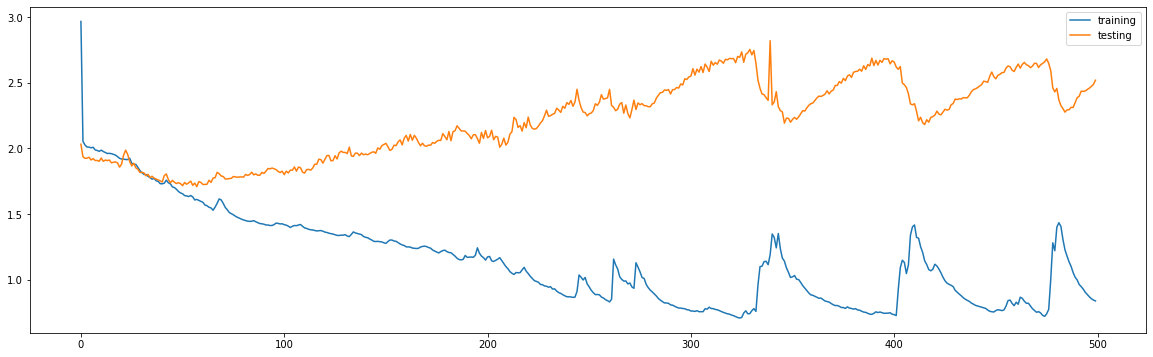

In [19]:
plt.figure(figsize=(20, 6))

plt.plot(hist.history['loss'], label='training')
plt.plot(hist.history['val_loss'], label='testing')
plt.legend()

plt.savefig(f'figures/{name}', dpi=400)

In [20]:
sequence_autoencoder = load_model(f'Models/{name}.hdf5')

In [21]:
preds = sequence_autoencoder.predict(X_train).argmax(axis=-1)
accuracy_score(y_train.argmax(-1).reshape(-1), preds.reshape(-1))

0.6790286144578314

In [22]:
preds = sequence_autoencoder.predict(X_test).argmax(axis=-1)
accuracy_score(y_test.argmax(-1).reshape(-1), preds.reshape(-1))

0.44568452380952384

## Model 2: Embedding-BiLSTM-BiLSTM Encoder, LSTM-Dense Decoder

In [23]:
name = 'NBG_bilstm_stacked'

In [24]:
timesteps = 64  # Length of your sequences
embed_size = 16
latent_dim = 256
dropout = 0

inputs = Input(shape=(timesteps,))
embedded = Embedding(vocab_size, embed_size)(inputs)
encoded = Bidirectional(LSTM(latent_dim, return_sequences=True, dropout=dropout))(embedded)
encoded = Bidirectional(LSTM(latent_dim, dropout=dropout))(embedded)

decoded = RepeatVector(timesteps)(encoded)
#decoded = LSTM(latent_dim, return_sequences=True, dropout=dropout)(decoded)
decoded = LSTM(latent_dim, return_sequences=True, dropout=dropout)(decoded)
decoded = Dense(vocab_size, activation='softmax')(decoded)
#decoded = argmax(decoded, axis=-1)
#decoded = cast(decoded, float)
#decoded = Reshape((decoded.shape[1], -1))(decoded)

sequence_autoencoder = Model(inputs, decoded)

In [25]:
sequence_autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 64, 16)            576       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               559104    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 64, 512)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64, 256)           787456    
_________________________________________________________________
dense_1 (Dense)              (None, 64, 36)            9252      
Total params: 1,356,388
Trainable params: 1,356,388
Non-trainable params: 0
_________________________________________________

In [26]:
encoder = Model(inputs, encoded)
# This is our encoded (32-dimensional) input
encoded_input = Input(shape=(2*latent_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layers = sequence_autoencoder.layers[-3:]
decoded_input = decoder_layers[0](encoded_input)
for decoder_layer in decoder_layers[1:]:
    decoded_input = decoder_layer(decoded_input)
# Create the decoder model
decoder = Model(encoded_input, decoded_input)

In [27]:
encoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 64, 16)            576       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               559104    
Total params: 559,680
Trainable params: 559,680
Non-trainable params: 0
_________________________________________________________________


In [28]:
decoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 64, 512)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64, 256)           787456    
_________________________________________________________________
dense_1 (Dense)              (None, 64, 36)            9252      
Total params: 796,708
Trainable params: 796,708
Non-trainable params: 0
_________________________________________________________________


In [29]:
lr = 5e-3

mc = ModelCheckpoint(f'Models/{name}.hdf5', monitor='val_loss')

optimizer = Adam(learning_rate=lr)

sequence_autoencoder.compile(optimizer, loss='categorical_crossentropy')

In [30]:
hist = sequence_autoencoder.fit(X_train, y_train,
                epochs=500,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder'), mc])

Epoch 1/500
6/6 [==============================] - 5s 346ms/step - loss: 3.2251 - val_loss: 2.0501
Epoch 2/500
6/6 [==============================] - 0s 44ms/step - loss: 2.0680 - val_loss: 1.9696
Epoch 3/500
6/6 [==============================] - 0s 40ms/step - loss: 2.0222 - val_loss: 1.9292
Epoch 4/500
6/6 [==============================] - 0s 38ms/step - loss: 1.9673 - val_loss: 1.9290
Epoch 5/500
6/6 [==============================] - 0s 39ms/step - loss: 2.0210 - val_loss: 1.9163
Epoch 6/500
6/6 [==============================] - 0s 44ms/step - loss: 2.0077 - val_loss: 1.9186
Epoch 7/500
6/6 [==============================] - 0s 45ms/step - loss: 2.0119 - val_loss: 1.9072
Epoch 8/500
6/6 [==============================] - 0s 45ms/step - loss: 2.0287 - val_loss: 1.9018
Epoch 9/500
6/6 [==============================] - 0s 46ms/step - loss: 1.9878 - val_loss: 1.9068
Epoch 10/500
6/6 [==============================] - 0s 42ms/step - loss: 2.0013 - val_loss: 1.8907
Epoch 11/500
6/6 [

Epoch 84/500
6/6 [==============================] - 0s 45ms/step - loss: 1.4359 - val_loss: 1.7174
Epoch 85/500
6/6 [==============================] - 0s 45ms/step - loss: 1.4515 - val_loss: 1.7275
Epoch 86/500
6/6 [==============================] - 0s 45ms/step - loss: 1.4205 - val_loss: 1.7322
Epoch 87/500
6/6 [==============================] - 0s 49ms/step - loss: 1.4082 - val_loss: 1.7320
Epoch 88/500
6/6 [==============================] - 0s 51ms/step - loss: 1.4097 - val_loss: 1.7235
Epoch 89/500
6/6 [==============================] - 0s 38ms/step - loss: 1.3954 - val_loss: 1.7275
Epoch 90/500
6/6 [==============================] - 0s 37ms/step - loss: 1.4116 - val_loss: 1.7403
Epoch 91/500
6/6 [==============================] - 0s 36ms/step - loss: 1.4005 - val_loss: 1.7557
Epoch 92/500
6/6 [==============================] - 0s 37ms/step - loss: 1.3868 - val_loss: 1.7386
Epoch 93/500
6/6 [==============================] - 0s 38ms/step - loss: 1.3755 - val_loss: 1.7389
Epoch 94/5

6/6 [==============================] - 0s 41ms/step - loss: 1.2657 - val_loss: 1.9428
Epoch 167/500
6/6 [==============================] - 0s 43ms/step - loss: 1.2541 - val_loss: 1.8919
Epoch 168/500
6/6 [==============================] - 0s 39ms/step - loss: 1.2661 - val_loss: 1.8913
Epoch 169/500
6/6 [==============================] - 0s 36ms/step - loss: 1.2297 - val_loss: 1.9309
Epoch 170/500
6/6 [==============================] - 0s 42ms/step - loss: 1.2712 - val_loss: 1.8916
Epoch 171/500
6/6 [==============================] - 0s 40ms/step - loss: 1.3140 - val_loss: 1.8769
Epoch 172/500
6/6 [==============================] - 0s 36ms/step - loss: 1.3083 - val_loss: 1.9045
Epoch 173/500
6/6 [==============================] - 0s 41ms/step - loss: 1.2681 - val_loss: 1.9373
Epoch 174/500
6/6 [==============================] - 0s 39ms/step - loss: 1.2882 - val_loss: 1.9314
Epoch 175/500
6/6 [==============================] - 0s 40ms/step - loss: 1.2529 - val_loss: 1.9409
Epoch 176/500


6/6 [==============================] - 0s 48ms/step - loss: 0.9433 - val_loss: 2.1034
Epoch 249/500
6/6 [==============================] - 0s 46ms/step - loss: 0.9485 - val_loss: 2.1502
Epoch 250/500
6/6 [==============================] - 0s 40ms/step - loss: 0.9922 - val_loss: 2.1399
Epoch 251/500
6/6 [==============================] - 0s 43ms/step - loss: 1.0013 - val_loss: 2.1125
Epoch 252/500
6/6 [==============================] - 0s 82ms/step - loss: 0.9950 - val_loss: 2.1214
Epoch 253/500
6/6 [==============================] - 0s 36ms/step - loss: 0.9798 - val_loss: 2.1274
Epoch 254/500
6/6 [==============================] - 0s 37ms/step - loss: 0.9633 - val_loss: 2.1284
Epoch 255/500
6/6 [==============================] - 0s 38ms/step - loss: 0.9559 - val_loss: 2.1187
Epoch 256/500
6/6 [==============================] - 0s 45ms/step - loss: 0.9507 - val_loss: 2.1325
Epoch 257/500
6/6 [==============================] - 0s 44ms/step - loss: 0.9359 - val_loss: 2.1363
Epoch 258/500


6/6 [==============================] - 0s 45ms/step - loss: 0.8606 - val_loss: 2.1616
Epoch 331/500
6/6 [==============================] - 0s 49ms/step - loss: 0.8677 - val_loss: 2.1775
Epoch 332/500
6/6 [==============================] - 0s 48ms/step - loss: 0.8767 - val_loss: 2.1786
Epoch 333/500
6/6 [==============================] - 0s 44ms/step - loss: 0.9150 - val_loss: 2.1613
Epoch 334/500
6/6 [==============================] - 0s 41ms/step - loss: 0.9261 - val_loss: 2.1727
Epoch 335/500
6/6 [==============================] - 0s 45ms/step - loss: 0.9504 - val_loss: 2.1442
Epoch 336/500
6/6 [==============================] - 0s 44ms/step - loss: 0.9838 - val_loss: 2.1991
Epoch 337/500
6/6 [==============================] - 0s 41ms/step - loss: 1.0462 - val_loss: 2.1350
Epoch 338/500
6/6 [==============================] - 0s 49ms/step - loss: 1.0093 - val_loss: 2.1191
Epoch 339/500
6/6 [==============================] - 0s 48ms/step - loss: 0.9768 - val_loss: 2.1615
Epoch 340/500


6/6 [==============================] - 0s 33ms/step - loss: 0.7297 - val_loss: 2.5695
Epoch 413/500
6/6 [==============================] - 0s 34ms/step - loss: 0.7334 - val_loss: 2.5619
Epoch 414/500
6/6 [==============================] - 0s 37ms/step - loss: 0.7703 - val_loss: 2.5377
Epoch 415/500
6/6 [==============================] - 0s 39ms/step - loss: 0.7481 - val_loss: 2.5467
Epoch 416/500
6/6 [==============================] - 0s 39ms/step - loss: 0.7464 - val_loss: 2.5129
Epoch 417/500
6/6 [==============================] - 0s 47ms/step - loss: 0.7324 - val_loss: 2.5385
Epoch 418/500
6/6 [==============================] - 0s 41ms/step - loss: 0.7445 - val_loss: 2.5375
Epoch 419/500
6/6 [==============================] - 0s 49ms/step - loss: 0.7066 - val_loss: 2.5473
Epoch 420/500
6/6 [==============================] - 0s 46ms/step - loss: 0.7034 - val_loss: 2.5543
Epoch 421/500
6/6 [==============================] - 0s 50ms/step - loss: 0.7142 - val_loss: 2.5585
Epoch 422/500


6/6 [==============================] - 0s 38ms/step - loss: 0.6976 - val_loss: 2.7404
Epoch 495/500
6/6 [==============================] - 0s 41ms/step - loss: 0.7024 - val_loss: 2.7311
Epoch 496/500
6/6 [==============================] - 0s 41ms/step - loss: 0.6888 - val_loss: 2.7324
Epoch 497/500
6/6 [==============================] - 0s 42ms/step - loss: 0.6932 - val_loss: 2.7652
Epoch 498/500
6/6 [==============================] - 0s 43ms/step - loss: 0.6800 - val_loss: 2.7680
Epoch 499/500
6/6 [==============================] - 0s 43ms/step - loss: 0.6738 - val_loss: 2.7907
Epoch 500/500
6/6 [==============================] - 0s 44ms/step - loss: 0.6708 - val_loss: 2.7876


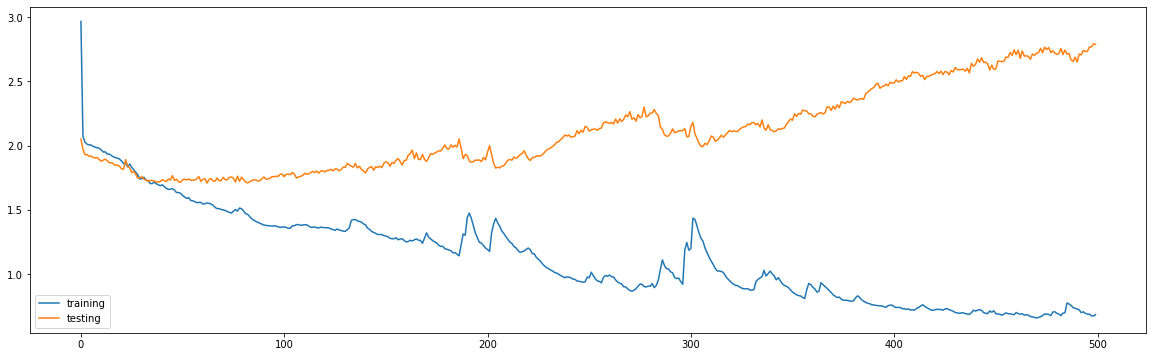

In [31]:
plt.figure(figsize=(20, 6))

plt.plot(hist.history['loss'], label='training')
plt.plot(hist.history['val_loss'], label='testing')
plt.legend()

plt.savefig(f'figures/{name}', dpi=400)

In [32]:
sequence_autoencoder = load_model(f'Models/{name}.hdf5')

In [33]:
preds = sequence_autoencoder.predict(X_train).argmax(axis=-1)
accuracy_score(y_train.argmax(-1).reshape(-1), preds.reshape(-1))

0.6993599397590361

In [34]:
preds = sequence_autoencoder.predict(X_test).argmax(axis=-1)
accuracy_score(y_test.argmax(-1).reshape(-1), preds.reshape(-1))

0.44642857142857145

## Model 3 Embedding-GRU Encoder GRU-Dense Decoder

In [35]:
name = 'NBG_gru'

In [36]:
timesteps = 64  # Length of your sequences
embed_size = 32
latent_dim = 256
dropout = 0

inputs = Input(shape=(timesteps,))
embedded = Embedding(vocab_size, embed_size)(inputs)
#encoded = LSTM(latent_dim, return_sequences=True, dropout=dropout)(embedded)
encoded = GRU(latent_dim, dropout=dropout)(embedded)

decoded = RepeatVector(timesteps)(encoded)
#decoded = LSTM(latent_dim, return_sequences=True, dropout=dropout)(decoded)
decoded = GRU(latent_dim, return_sequences=True, dropout=dropout)(decoded)
decoded = Dense(vocab_size, activation='softmax')(decoded)
#decoded = argmax(decoded, axis=-1)
#decoded = cast(decoded, float)
#decoded = Reshape((decoded.shape[1], -1))(decoded)

sequence_autoencoder = Model(inputs, decoded)

In [37]:
sequence_autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 64, 32)            1152      
_________________________________________________________________
gru (GRU)                    (None, 256)               222720    
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 64, 256)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64, 256)           394752    
_________________________________________________________________
dense_2 (Dense)              (None, 64, 36)            9252      
Total params: 627,876
Trainable params: 627,876
Non-trainable params: 0
_____________________________________________________

In [38]:
encoder = Model(inputs, encoded)
# This is our encoded (32-dimensional) input
encoded_input = Input(shape=(latent_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layers = sequence_autoencoder.layers[-3:]
decoded_input = decoder_layers[0](encoded_input)
for decoder_layer in decoder_layers[1:]:
    decoded_input = decoder_layer(decoded_input)
# Create the decoder model
decoder = Model(encoded_input, decoded_input)

In [39]:
encoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 64, 32)            1152      
_________________________________________________________________
gru (GRU)                    (None, 256)               222720    
Total params: 223,872
Trainable params: 223,872
Non-trainable params: 0
_________________________________________________________________


In [40]:
decoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 64, 256)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64, 256)           394752    
_________________________________________________________________
dense_2 (Dense)              (None, 64, 36)            9252      
Total params: 404,004
Trainable params: 404,004
Non-trainable params: 0
_________________________________________________________________


In [41]:
lr = 5e-3

mc = ModelCheckpoint(f'Models/{name}.hdf5', monitor='val_loss')

optimizer = Adam(learning_rate=lr)

sequence_autoencoder.compile(optimizer, loss='categorical_crossentropy')

In [42]:
hist = sequence_autoencoder.fit(X_train, y_train,
                epochs=500,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder'), mc])

Epoch 1/500
6/6 [==============================] - 4s 239ms/step - loss: 3.6563 - val_loss: 2.3175
Epoch 2/500
6/6 [==============================] - 0s 31ms/step - loss: 2.4409 - val_loss: 1.9796
Epoch 3/500
6/6 [==============================] - 0s 33ms/step - loss: 2.0341 - val_loss: 1.9585
Epoch 4/500
6/6 [==============================] - 0s 32ms/step - loss: 2.0312 - val_loss: 1.9442
Epoch 5/500
6/6 [==============================] - 0s 41ms/step - loss: 2.0234 - val_loss: 1.9470
Epoch 6/500
6/6 [==============================] - 0s 42ms/step - loss: 1.9915 - val_loss: 1.9094
Epoch 7/500
6/6 [==============================] - 0s 40ms/step - loss: 1.9582 - val_loss: 1.9307
Epoch 8/500
6/6 [==============================] - 0s 39ms/step - loss: 2.0229 - val_loss: 1.8891
Epoch 9/500
6/6 [==============================] - 0s 36ms/step - loss: 1.9923 - val_loss: 1.9212
Epoch 10/500
6/6 [==============================] - 0s 36ms/step - loss: 1.9434 - val_loss: 1.8720
Epoch 11/500
6/6 [

Epoch 84/500
6/6 [==============================] - 0s 33ms/step - loss: 1.3951 - val_loss: 1.6911
Epoch 85/500
6/6 [==============================] - 0s 33ms/step - loss: 1.4121 - val_loss: 1.6623
Epoch 86/500
6/6 [==============================] - 0s 40ms/step - loss: 1.4007 - val_loss: 1.6780
Epoch 87/500
6/6 [==============================] - 0s 39ms/step - loss: 1.3978 - val_loss: 1.6546
Epoch 88/500
6/6 [==============================] - 0s 40ms/step - loss: 1.4031 - val_loss: 1.6619
Epoch 89/500
6/6 [==============================] - 0s 43ms/step - loss: 1.3913 - val_loss: 1.6586
Epoch 90/500
6/6 [==============================] - 0s 39ms/step - loss: 1.3858 - val_loss: 1.6715
Epoch 91/500
6/6 [==============================] - 0s 37ms/step - loss: 1.3907 - val_loss: 1.6818
Epoch 92/500
6/6 [==============================] - 0s 35ms/step - loss: 1.3794 - val_loss: 1.6786
Epoch 93/500
6/6 [==============================] - 0s 38ms/step - loss: 1.3841 - val_loss: 1.6632
Epoch 94/5

6/6 [==============================] - 0s 39ms/step - loss: 1.3013 - val_loss: 1.7595
Epoch 167/500
6/6 [==============================] - 0s 34ms/step - loss: 1.3252 - val_loss: 1.7419
Epoch 168/500
6/6 [==============================] - 0s 35ms/step - loss: 1.2983 - val_loss: 1.7539
Epoch 169/500
6/6 [==============================] - 0s 38ms/step - loss: 1.3279 - val_loss: 1.7716
Epoch 170/500
6/6 [==============================] - 0s 38ms/step - loss: 1.3171 - val_loss: 1.7691
Epoch 171/500
6/6 [==============================] - 0s 34ms/step - loss: 1.3152 - val_loss: 1.7778
Epoch 172/500
6/6 [==============================] - 0s 35ms/step - loss: 1.3221 - val_loss: 1.7914
Epoch 173/500
6/6 [==============================] - 0s 38ms/step - loss: 1.3121 - val_loss: 1.8019
Epoch 174/500
6/6 [==============================] - 0s 38ms/step - loss: 1.3088 - val_loss: 1.8066
Epoch 175/500
6/6 [==============================] - 0s 39ms/step - loss: 1.3081 - val_loss: 1.7648
Epoch 176/500


6/6 [==============================] - 0s 41ms/step - loss: 1.3088 - val_loss: 1.8590
Epoch 249/500
6/6 [==============================] - 0s 33ms/step - loss: 1.2839 - val_loss: 1.8559
Epoch 250/500
6/6 [==============================] - 0s 34ms/step - loss: 1.2373 - val_loss: 1.8637
Epoch 251/500
6/6 [==============================] - 0s 35ms/step - loss: 1.2473 - val_loss: 1.8473
Epoch 252/500
6/6 [==============================] - 0s 36ms/step - loss: 1.2336 - val_loss: 1.8493
Epoch 253/500
6/6 [==============================] - 0s 33ms/step - loss: 1.2120 - val_loss: 1.8198
Epoch 254/500
6/6 [==============================] - 0s 32ms/step - loss: 1.2409 - val_loss: 1.8285
Epoch 255/500
6/6 [==============================] - 0s 34ms/step - loss: 1.2249 - val_loss: 1.8635
Epoch 256/500
6/6 [==============================] - 0s 40ms/step - loss: 1.3581 - val_loss: 1.8708
Epoch 257/500
6/6 [==============================] - 0s 39ms/step - loss: 1.4418 - val_loss: 1.8139
Epoch 258/500


6/6 [==============================] - 0s 39ms/step - loss: 1.3094 - val_loss: 1.8945
Epoch 331/500
6/6 [==============================] - 0s 38ms/step - loss: 1.2997 - val_loss: 1.9003
Epoch 332/500
6/6 [==============================] - 0s 40ms/step - loss: 1.3055 - val_loss: 1.9449
Epoch 333/500
6/6 [==============================] - 0s 40ms/step - loss: 1.2880 - val_loss: 1.9420
Epoch 334/500
6/6 [==============================] - 0s 41ms/step - loss: 1.2664 - val_loss: 1.8997
Epoch 335/500
6/6 [==============================] - 0s 41ms/step - loss: 1.2334 - val_loss: 1.9233
Epoch 336/500
6/6 [==============================] - 0s 37ms/step - loss: 1.2182 - val_loss: 1.9172
Epoch 337/500
6/6 [==============================] - 0s 40ms/step - loss: 1.2429 - val_loss: 1.9316
Epoch 338/500
6/6 [==============================] - 0s 40ms/step - loss: 1.2387 - val_loss: 1.9023
Epoch 339/500
6/6 [==============================] - 0s 38ms/step - loss: 1.2067 - val_loss: 1.9586
Epoch 340/500


6/6 [==============================] - 0s 37ms/step - loss: 1.1867 - val_loss: 1.9585
Epoch 413/500
6/6 [==============================] - 0s 39ms/step - loss: 1.1812 - val_loss: 1.9412
Epoch 414/500
6/6 [==============================] - 0s 39ms/step - loss: 1.1699 - val_loss: 1.9684
Epoch 415/500
6/6 [==============================] - 0s 35ms/step - loss: 1.1376 - val_loss: 1.9612
Epoch 416/500
6/6 [==============================] - 0s 35ms/step - loss: 1.1733 - val_loss: 1.9800
Epoch 417/500
6/6 [==============================] - 0s 39ms/step - loss: 1.1502 - val_loss: 1.9648
Epoch 418/500
6/6 [==============================] - 0s 36ms/step - loss: 1.1635 - val_loss: 1.9662
Epoch 419/500
6/6 [==============================] - 0s 38ms/step - loss: 1.1996 - val_loss: 1.9418
Epoch 420/500
6/6 [==============================] - 0s 41ms/step - loss: 1.1661 - val_loss: 1.9599
Epoch 421/500
6/6 [==============================] - 0s 40ms/step - loss: 1.1817 - val_loss: 1.9718
Epoch 422/500


6/6 [==============================] - 0s 32ms/step - loss: 1.2300 - val_loss: 2.0761
Epoch 495/500
6/6 [==============================] - 0s 33ms/step - loss: 1.2240 - val_loss: 2.0657
Epoch 496/500
6/6 [==============================] - 0s 33ms/step - loss: 1.2557 - val_loss: 2.0928
Epoch 497/500
6/6 [==============================] - 0s 31ms/step - loss: 1.2344 - val_loss: 2.0729
Epoch 498/500
6/6 [==============================] - 0s 31ms/step - loss: 1.2584 - val_loss: 2.1069
Epoch 499/500
6/6 [==============================] - 0s 34ms/step - loss: 1.3002 - val_loss: 2.1054
Epoch 500/500
6/6 [==============================] - 0s 31ms/step - loss: 1.2797 - val_loss: 2.1199


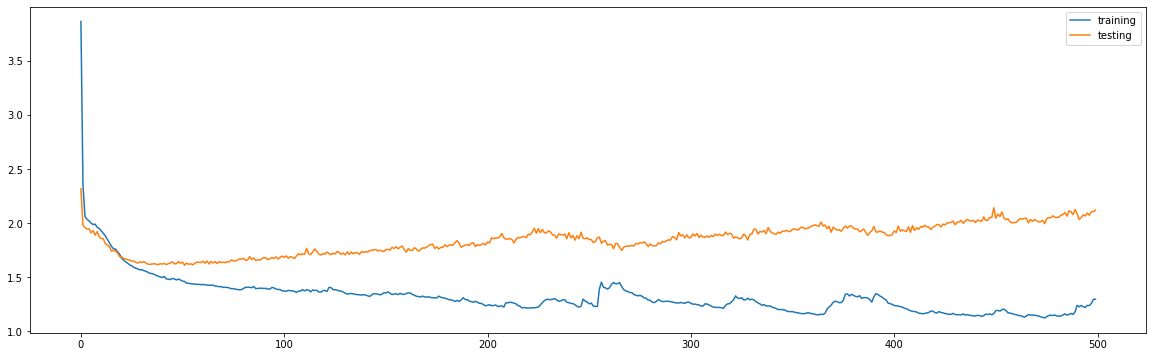

In [43]:
plt.figure(figsize=(20, 6))

plt.plot(hist.history['loss'], label='training')
plt.plot(hist.history['val_loss'], label='testing')
plt.legend()

plt.savefig(f'figures/{name}', dpi=400)

In [44]:
sequence_autoencoder = load_model(f'Models/{name}.hdf5')

In [45]:
preds = sequence_autoencoder.predict(X_train).argmax(axis=-1)
accuracy_score(y_train.argmax(-1).reshape(-1), preds.reshape(-1))

0.5378388554216867

In [46]:
preds = sequence_autoencoder.predict(X_test).argmax(axis=-1)
accuracy_score(y_test.argmax(-1).reshape(-1), preds.reshape(-1))

0.4296875

## Model 4: Embedding-Conv1D-MaxPooling1D-Conv1D-MaxPooling1D-Conv1D Encoder Conv1D-Upsampling1D-Conv1D-Upsampling1D-Conv1D-Dense Decoder

In [47]:
name = 'NBG_conv'

In [48]:
timesteps = 64  # Length of your sequences
embed_size = 32
latent_dim = 256
dropout = 0

inputs = Input(shape=(timesteps,))
embedded = Embedding(vocab_size, embed_size)(inputs)
encoded = Conv1D(latent_dim, 3, activation='relu', padding='same')(embedded)
encoded = MaxPooling1D(2, padding='same')(encoded)
encoded = Conv1D(2 * latent_dim, 3, activation='relu', padding='same')(encoded)
encoded = MaxPooling1D(2, padding='same')(encoded)

decoded = Conv1D(2 * latent_dim, 3, activation='relu', padding='same')(encoded)
decoded = UpSampling1D(2)(decoded)
decoded = Conv1D(latent_dim, 3, activation='relu', padding='same')(decoded)
decoded = UpSampling1D(2)(decoded)
decoded = Conv1D(1, 3, activation='relu', padding='same')(decoded)
decoded = Dense(vocab_size, activation='softmax')(decoded)

sequence_autoencoder = Model(inputs, decoded)

In [49]:
sequence_autoencoder.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 64, 32)            1152      
_________________________________________________________________
conv1d (Conv1D)              (None, 64, 256)           24832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 512)           393728    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 512)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 512)           7869

In [50]:
encoder = Model(inputs, encoded)
# This is our encoded (32-dimensional) input
encoded_input = Input(shape=(timesteps//4,2*latent_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layers = sequence_autoencoder.layers[-6:]
decoded_input = decoder_layers[0](encoded_input)
for decoder_layer in decoder_layers[1:]:
    decoded_input = decoder_layer(decoded_input)
# Create the decoder model
decoder = Model(encoded_input, decoded_input)

In [51]:
encoder.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 64, 32)            1152      
_________________________________________________________________
conv1d (Conv1D)              (None, 64, 256)           24832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 512)           393728    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 512)           0         
Total params: 419,712
Trainable params: 419,712
Non-trainable params: 0
____________________________________________________

In [52]:
decoder.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 16, 512)]         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 512)           786944    
_________________________________________________________________
up_sampling1d (UpSampling1D) (None, 32, 512)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 32, 256)           393472    
_________________________________________________________________
up_sampling1d_1 (UpSampling1 (None, 64, 256)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 64, 1)             769       
_________________________________________________________________
dense_3 (Dense)              (None, 64, 36)            72 

In [53]:
lr = 5e-3

mc = ModelCheckpoint(f'Models/{name}.hdf5', monitor='val_loss')

optimizer = Adam(learning_rate=lr)

sequence_autoencoder.compile(optimizer, loss='categorical_crossentropy')

In [54]:
hist = sequence_autoencoder.fit(X_train, y_train,
                epochs=500,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder'), mc])

Epoch 1/500
6/6 [==============================] - 3s 221ms/step - loss: 3.5750 - val_loss: 3.5440
Epoch 2/500
6/6 [==============================] - 0s 27ms/step - loss: 3.5361 - val_loss: 3.5051
Epoch 3/500
6/6 [==============================] - 0s 25ms/step - loss: 3.4979 - val_loss: 3.4665
Epoch 4/500
6/6 [==============================] - 0s 26ms/step - loss: 3.4608 - val_loss: 3.4283
Epoch 5/500
6/6 [==============================] - 0s 24ms/step - loss: 3.4240 - val_loss: 3.3906
Epoch 6/500
6/6 [==============================] - 0s 26ms/step - loss: 3.3880 - val_loss: 3.3535
Epoch 7/500
6/6 [==============================] - 0s 29ms/step - loss: 3.3512 - val_loss: 3.3168
Epoch 8/500
6/6 [==============================] - 0s 28ms/step - loss: 3.3170 - val_loss: 3.2803
Epoch 9/500
6/6 [==============================] - 0s 31ms/step - loss: 3.2787 - val_loss: 3.2442
Epoch 10/500
6/6 [==============================] - 0s 34ms/step - loss: 3.2428 - val_loss: 3.2087
Epoch 11/500
6/6 [

Epoch 84/500
6/6 [==============================] - 0s 35ms/step - loss: 2.0947 - val_loss: 2.0109
Epoch 85/500
6/6 [==============================] - 0s 37ms/step - loss: 2.0796 - val_loss: 2.0077
Epoch 86/500
6/6 [==============================] - 0s 38ms/step - loss: 2.0898 - val_loss: 2.0047
Epoch 87/500
6/6 [==============================] - 0s 35ms/step - loss: 2.0948 - val_loss: 2.0017
Epoch 88/500
6/6 [==============================] - 0s 38ms/step - loss: 2.0777 - val_loss: 1.9988
Epoch 89/500
6/6 [==============================] - 0s 36ms/step - loss: 2.0587 - val_loss: 1.9961
Epoch 90/500
6/6 [==============================] - 0s 36ms/step - loss: 2.0569 - val_loss: 1.9935
Epoch 91/500
6/6 [==============================] - 0s 38ms/step - loss: 2.0523 - val_loss: 1.9912
Epoch 92/500
6/6 [==============================] - 0s 38ms/step - loss: 2.0570 - val_loss: 1.9889
Epoch 93/500
6/6 [==============================] - 0s 38ms/step - loss: 2.0509 - val_loss: 1.9869
Epoch 94/5

6/6 [==============================] - 0s 29ms/step - loss: 2.0121 - val_loss: 1.9305
Epoch 167/500
6/6 [==============================] - 0s 31ms/step - loss: 1.9996 - val_loss: 1.9302
Epoch 168/500
6/6 [==============================] - 0s 33ms/step - loss: 2.0352 - val_loss: 1.9301
Epoch 169/500
6/6 [==============================] - 0s 36ms/step - loss: 2.0221 - val_loss: 1.9299
Epoch 170/500
6/6 [==============================] - 0s 32ms/step - loss: 1.9958 - val_loss: 1.9297
Epoch 171/500
6/6 [==============================] - 0s 33ms/step - loss: 2.0426 - val_loss: 1.9295
Epoch 172/500
6/6 [==============================] - 0s 37ms/step - loss: 2.0061 - val_loss: 1.9294
Epoch 173/500
6/6 [==============================] - 0s 37ms/step - loss: 2.0262 - val_loss: 1.9292
Epoch 174/500
6/6 [==============================] - 0s 36ms/step - loss: 1.9989 - val_loss: 1.9290
Epoch 175/500
6/6 [==============================] - 0s 62ms/step - loss: 2.0276 - val_loss: 1.9288
Epoch 176/500


6/6 [==============================] - 0s 36ms/step - loss: 1.9889 - val_loss: 1.9214
Epoch 249/500
6/6 [==============================] - 0s 34ms/step - loss: 1.9895 - val_loss: 1.9213
Epoch 250/500
6/6 [==============================] - 0s 36ms/step - loss: 2.0330 - val_loss: 1.9213
Epoch 251/500
6/6 [==============================] - 0s 38ms/step - loss: 2.0010 - val_loss: 1.9214
Epoch 252/500
6/6 [==============================] - 0s 33ms/step - loss: 1.9981 - val_loss: 1.9213
Epoch 253/500
6/6 [==============================] - 0s 65ms/step - loss: 1.9937 - val_loss: 1.9212
Epoch 254/500
6/6 [==============================] - 0s 33ms/step - loss: 2.0349 - val_loss: 1.9212
Epoch 255/500
6/6 [==============================] - 0s 35ms/step - loss: 2.0074 - val_loss: 1.9211
Epoch 256/500
6/6 [==============================] - 0s 32ms/step - loss: 2.0050 - val_loss: 1.9211
Epoch 257/500
6/6 [==============================] - 0s 30ms/step - loss: 2.0216 - val_loss: 1.9211
Epoch 258/500


6/6 [==============================] - 0s 36ms/step - loss: 1.9849 - val_loss: 1.9201
Epoch 331/500
6/6 [==============================] - 0s 61ms/step - loss: 1.9854 - val_loss: 1.9202
Epoch 332/500
6/6 [==============================] - 0s 35ms/step - loss: 2.0119 - val_loss: 1.9203
Epoch 333/500
6/6 [==============================] - 0s 30ms/step - loss: 2.0071 - val_loss: 1.9203
Epoch 334/500
6/6 [==============================] - 0s 32ms/step - loss: 2.0180 - val_loss: 1.9201
Epoch 335/500
6/6 [==============================] - 0s 38ms/step - loss: 1.9973 - val_loss: 1.9198
Epoch 336/500
6/6 [==============================] - 0s 37ms/step - loss: 2.0202 - val_loss: 1.9197
Epoch 337/500
6/6 [==============================] - 0s 35ms/step - loss: 2.0134 - val_loss: 1.9195
Epoch 338/500
6/6 [==============================] - 0s 36ms/step - loss: 2.0100 - val_loss: 1.9196
Epoch 339/500
6/6 [==============================] - 0s 39ms/step - loss: 2.0179 - val_loss: 1.9197
Epoch 340/500


6/6 [==============================] - 0s 32ms/step - loss: 1.9865 - val_loss: 1.9193
Epoch 413/500
6/6 [==============================] - 0s 36ms/step - loss: 2.0005 - val_loss: 1.9193
Epoch 414/500
6/6 [==============================] - 0s 35ms/step - loss: 2.0128 - val_loss: 1.9192
Epoch 415/500
6/6 [==============================] - 0s 33ms/step - loss: 2.0319 - val_loss: 1.9191
Epoch 416/500
6/6 [==============================] - 0s 39ms/step - loss: 2.0103 - val_loss: 1.9189
Epoch 417/500
6/6 [==============================] - 0s 37ms/step - loss: 1.9987 - val_loss: 1.9188
Epoch 418/500
6/6 [==============================] - 0s 35ms/step - loss: 1.9884 - val_loss: 1.9187
Epoch 419/500
6/6 [==============================] - 0s 33ms/step - loss: 1.9805 - val_loss: 1.9187
Epoch 420/500
6/6 [==============================] - 0s 35ms/step - loss: 2.0017 - val_loss: 1.9189
Epoch 421/500
6/6 [==============================] - 0s 37ms/step - loss: 1.9779 - val_loss: 1.9191
Epoch 422/500


6/6 [==============================] - 0s 29ms/step - loss: 1.9831 - val_loss: 1.9206
Epoch 495/500
6/6 [==============================] - 0s 31ms/step - loss: 1.9831 - val_loss: 1.9207
Epoch 496/500
6/6 [==============================] - 0s 33ms/step - loss: 1.9747 - val_loss: 1.9210
Epoch 497/500
6/6 [==============================] - 0s 33ms/step - loss: 1.9954 - val_loss: 1.9210
Epoch 498/500
6/6 [==============================] - 0s 33ms/step - loss: 2.0154 - val_loss: 1.9209
Epoch 499/500
6/6 [==============================] - 0s 32ms/step - loss: 1.9871 - val_loss: 1.9206
Epoch 500/500
6/6 [==============================] - 0s 38ms/step - loss: 1.9877 - val_loss: 1.9203


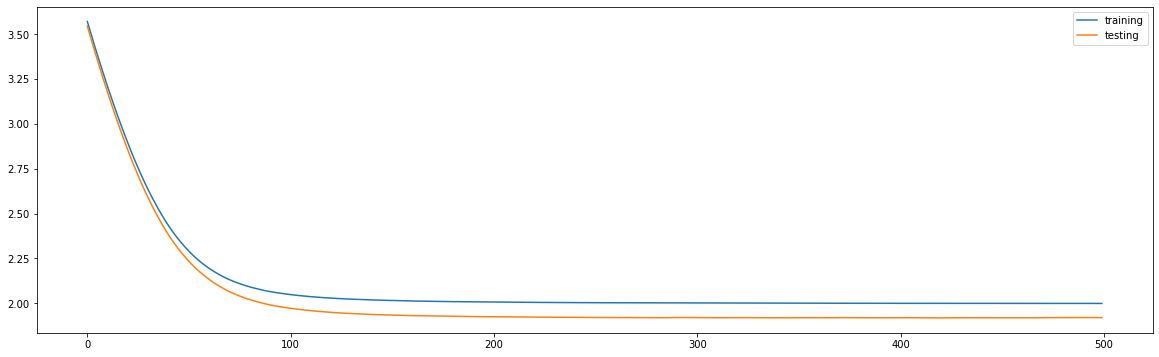

In [55]:
plt.figure(figsize=(20, 6))

plt.plot(hist.history['loss'], label='training')
plt.plot(hist.history['val_loss'], label='testing')
plt.legend()

plt.savefig(f'figures/{name}', dpi=400)

In [56]:
sequence_autoencoder = load_model(f'Models/{name}.hdf5')

In [57]:
preds = sequence_autoencoder.predict(X_train).argmax(axis=-1)
accuracy_score(y_train.argmax(-1).reshape(-1), preds.reshape(-1))

0.4605609939759036

In [58]:
preds = sequence_autoencoder.predict(X_test).argmax(axis=-1)
accuracy_score(y_test.argmax(-1).reshape(-1), preds.reshape(-1))

0.4962797619047619

In [59]:
from sklearn.mixture import GaussianMixture

train_encoded = encoder(X_train).numpy()

In [60]:
gm1 = GaussianMixture(n_components=5)
gm1.fit(train_encoded.reshape(num_train, -1))

KeyboardInterrupt: 

In [ ]:
samples1 = gm1.sample(10)

samples1[0]

In [ ]:
trials = samples1[0].reshape(10, 16, 512)

In [ ]:
preds = decoder(trials).numpy().argmax(-1)

In [ ]:
preds = replace_with_dict(preds, v2n_mapping)

In [ ]:
pd.DataFrame(preds).to_csv("FirstOut.csv", index=False)

In [ ]:
pd.read_csv("FirstOut.csv")

## Model 5: Embedding-LSTM Encoder Embedding-LSTM-Dense Decoder Bassline Model

In [69]:
X_train, X_test, y_train, y_test = train_test_split(minor_data, minor_data, test_size=0.1, random_state=42)

In [70]:
num_train = X_train.shape[0]

num_test = X_test.shape[0]

In [71]:
timesteps = 64

n2v_mapping['<bon/>'] = 36
v2n_mapping = {value:key for key, value in n2v_mapping.items()}
vocab_size = len(n2v_mapping)

encoder_inputs_training = X_train
decoder_inputs_training = np.ones((num_train, timesteps))
decoder_inputs_training[:,0] *= n2v_mapping['<bon/>']
decoder_inputs_training[:,1:] = X_train[:,:-1]
#decoder_outputs_training = np.ones((num_train, timesteps))
#decoder_outputs_training[:,-1] *= n2v_mapping['<bon/>']
#decoder_outputs_training[:,:-1] = X_train
#decoder_outputs_training = one_hot_encode(decoder_outputs_training, vocab_size)
decoder_outputs_training = one_hot_encode(X_train, vocab_size)

encoder_inputs_testing = X_test
decoder_inputs_testing = np.ones((num_test, timesteps))
decoder_inputs_testing[:,0] *= n2v_mapping['<bon/>']
decoder_inputs_testing[:,1:] = X_test[:,:-1]
#decoder_outputs_testing = np.ones((num_test, timesteps))
#decoder_outputs_testing[:,-1] *= n2v_mapping['<bon/>']
#decoder_outputs_testing[:,:-1] = X_test[:,1:]
#decoder_outputs_testing = one_hot_encode(decoder_outputs_testing, vocab_size)
decoder_outputs_testing = one_hot_encode(X_test, vocab_size)

In [72]:
decoder_outputs_training.shape

(187, 64, 37)

In [73]:
name = 'NBG_lm_lstm'

In [74]:
embed_size = 32
latent_dim = 256
dropout = 0.

encoder_inputs = Input(shape=(timesteps,))
embedding = Embedding(vocab_size, embed_size)
encoder_embedding_outputs = embedding(encoder_inputs)
encoder = LSTM(latent_dim, return_state=True, dropout=dropout)
encoder_outputs, state_h, state_c = encoder(encoder_embedding_outputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(timesteps,))
decoder_embedding_outputs = embedding(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=dropout)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding_outputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [75]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 64)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 64, 32)       1184        input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
lstm_7 (LSTM)                   [(None, 256), (None, 295936      embedding_5[0][0]         

In [76]:
batch_size = 32
epochs = 500
lr = 5e-3

mc = ModelCheckpoint(f'Models/{name}.hdf5', monitor='val_loss')

optimizer = Adam(learning_rate=lr)

model.compile(optimizer, loss='categorical_crossentropy')
hist = model.fit([encoder_inputs_training, decoder_inputs_training], decoder_outputs_training,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=([encoder_inputs_testing, decoder_inputs_testing], decoder_outputs_testing),
                 callbacks=[mc]
                )

Epoch 1/500
6/6 [==============================] - 3s 201ms/step - loss: 3.0739 - val_loss: 2.1161
Epoch 2/500
6/6 [==============================] - 0s 33ms/step - loss: 2.0140 - val_loss: 2.0283
Epoch 3/500
6/6 [==============================] - 0s 33ms/step - loss: 1.9644 - val_loss: 2.0317
Epoch 4/500
6/6 [==============================] - 0s 32ms/step - loss: 1.9497 - val_loss: 2.0160
Epoch 5/500
6/6 [==============================] - 0s 30ms/step - loss: 1.9399 - val_loss: 2.0019
Epoch 6/500
6/6 [==============================] - 0s 33ms/step - loss: 1.9665 - val_loss: 1.9890
Epoch 7/500
6/6 [==============================] - 0s 31ms/step - loss: 1.9329 - val_loss: 1.9802
Epoch 8/500
6/6 [==============================] - 0s 31ms/step - loss: 1.8718 - val_loss: 1.9814
Epoch 9/500
6/6 [==============================] - 0s 38ms/step - loss: 1.8368 - val_loss: 1.9580
Epoch 10/500
6/6 [==============================] - 0s 36ms/step - loss: 1.8554 - val_loss: 1.9239
Epoch 11/500
6/6 [

Epoch 84/500
6/6 [==============================] - 0s 33ms/step - loss: 0.3508 - val_loss: 2.4808
Epoch 85/500
6/6 [==============================] - 0s 33ms/step - loss: 0.3488 - val_loss: 2.4789
Epoch 86/500
6/6 [==============================] - 0s 32ms/step - loss: 0.3067 - val_loss: 2.5401
Epoch 87/500
6/6 [==============================] - 0s 38ms/step - loss: 0.2897 - val_loss: 2.5186
Epoch 88/500
6/6 [==============================] - 0s 36ms/step - loss: 0.2486 - val_loss: 2.5816
Epoch 89/500
6/6 [==============================] - 0s 33ms/step - loss: 0.2253 - val_loss: 2.6984
Epoch 90/500
6/6 [==============================] - 0s 36ms/step - loss: 0.1963 - val_loss: 2.6665
Epoch 91/500
6/6 [==============================] - 0s 33ms/step - loss: 0.2139 - val_loss: 2.6901
Epoch 92/500
6/6 [==============================] - 0s 35ms/step - loss: 0.1873 - val_loss: 2.7058
Epoch 93/500
6/6 [==============================] - 0s 37ms/step - loss: 0.1619 - val_loss: 2.7502
Epoch 94/5

6/6 [==============================] - 0s 32ms/step - loss: 0.0133 - val_loss: 3.7180
Epoch 167/500
6/6 [==============================] - 0s 32ms/step - loss: 0.0133 - val_loss: 3.7354
Epoch 168/500
6/6 [==============================] - 0s 32ms/step - loss: 0.0126 - val_loss: 3.7554
Epoch 169/500
6/6 [==============================] - 0s 34ms/step - loss: 0.0116 - val_loss: 3.7701
Epoch 170/500
6/6 [==============================] - 0s 64ms/step - loss: 0.0115 - val_loss: 3.7468
Epoch 171/500
6/6 [==============================] - 0s 31ms/step - loss: 0.0111 - val_loss: 3.7645
Epoch 172/500
6/6 [==============================] - 0s 31ms/step - loss: 0.0105 - val_loss: 3.7942
Epoch 173/500
6/6 [==============================] - 0s 31ms/step - loss: 0.0112 - val_loss: 3.8126
Epoch 174/500
6/6 [==============================] - 0s 30ms/step - loss: 0.0119 - val_loss: 3.8015
Epoch 175/500
6/6 [==============================] - 0s 39ms/step - loss: 0.0115 - val_loss: 3.8049
Epoch 176/500


6/6 [==============================] - 0s 37ms/step - loss: 0.0077 - val_loss: 4.1007
Epoch 249/500
6/6 [==============================] - 0s 35ms/step - loss: 0.0082 - val_loss: 4.1103
Epoch 250/500
6/6 [==============================] - 0s 39ms/step - loss: 0.0070 - val_loss: 4.1228
Epoch 251/500
6/6 [==============================] - 0s 39ms/step - loss: 0.0075 - val_loss: 4.1444
Epoch 252/500
6/6 [==============================] - 0s 43ms/step - loss: 0.0072 - val_loss: 4.1220
Epoch 253/500
6/6 [==============================] - 0s 38ms/step - loss: 0.0075 - val_loss: 4.1399
Epoch 254/500
6/6 [==============================] - 0s 38ms/step - loss: 0.0062 - val_loss: 4.1555
Epoch 255/500
6/6 [==============================] - 0s 36ms/step - loss: 0.0048 - val_loss: 4.1631
Epoch 256/500
6/6 [==============================] - 0s 39ms/step - loss: 0.0048 - val_loss: 4.1883
Epoch 257/500
6/6 [==============================] - 0s 35ms/step - loss: 0.0054 - val_loss: 4.1784
Epoch 258/500


6/6 [==============================] - 0s 38ms/step - loss: 0.0757 - val_loss: 3.0498
Epoch 331/500
6/6 [==============================] - 0s 35ms/step - loss: 0.0660 - val_loss: 3.0712
Epoch 332/500
6/6 [==============================] - 0s 39ms/step - loss: 0.0572 - val_loss: 3.1072
Epoch 333/500
6/6 [==============================] - 0s 34ms/step - loss: 0.0509 - val_loss: 3.1423
Epoch 334/500
6/6 [==============================] - 0s 32ms/step - loss: 0.0448 - val_loss: 3.1702
Epoch 335/500
6/6 [==============================] - 0s 35ms/step - loss: 0.0396 - val_loss: 3.1957
Epoch 336/500
6/6 [==============================] - 0s 36ms/step - loss: 0.0369 - val_loss: 3.2234
Epoch 337/500
6/6 [==============================] - 0s 37ms/step - loss: 0.0344 - val_loss: 3.2476
Epoch 338/500
6/6 [==============================] - 0s 36ms/step - loss: 0.0323 - val_loss: 3.2820
Epoch 339/500
6/6 [==============================] - 0s 34ms/step - loss: 0.0308 - val_loss: 3.2849
Epoch 340/500


6/6 [==============================] - 0s 32ms/step - loss: 0.0040 - val_loss: 3.9173
Epoch 413/500
6/6 [==============================] - 0s 31ms/step - loss: 0.0042 - val_loss: 3.9246
Epoch 414/500
6/6 [==============================] - 0s 38ms/step - loss: 0.0039 - val_loss: 3.9222
Epoch 415/500
6/6 [==============================] - 0s 36ms/step - loss: 0.0042 - val_loss: 3.9264
Epoch 416/500
6/6 [==============================] - 0s 33ms/step - loss: 0.0038 - val_loss: 3.9381
Epoch 417/500
6/6 [==============================] - 0s 32ms/step - loss: 0.0039 - val_loss: 3.9515
Epoch 418/500
6/6 [==============================] - 0s 34ms/step - loss: 0.0037 - val_loss: 3.9487
Epoch 419/500
6/6 [==============================] - 0s 38ms/step - loss: 0.0032 - val_loss: 3.9569
Epoch 420/500
6/6 [==============================] - 0s 33ms/step - loss: 0.0036 - val_loss: 3.9646
Epoch 421/500
6/6 [==============================] - 0s 32ms/step - loss: 0.0035 - val_loss: 3.9627
Epoch 422/500


6/6 [==============================] - 0s 36ms/step - loss: 0.0054 - val_loss: 4.1308
Epoch 495/500
6/6 [==============================] - 0s 37ms/step - loss: 0.0046 - val_loss: 4.1382
Epoch 496/500
6/6 [==============================] - 0s 39ms/step - loss: 0.0048 - val_loss: 4.1430
Epoch 497/500
6/6 [==============================] - 0s 39ms/step - loss: 0.0042 - val_loss: 4.1541
Epoch 498/500
6/6 [==============================] - 0s 43ms/step - loss: 0.0043 - val_loss: 4.1579
Epoch 499/500
6/6 [==============================] - 0s 39ms/step - loss: 0.0043 - val_loss: 4.1661
Epoch 500/500
6/6 [==============================] - 0s 37ms/step - loss: 0.0050 - val_loss: 4.1816


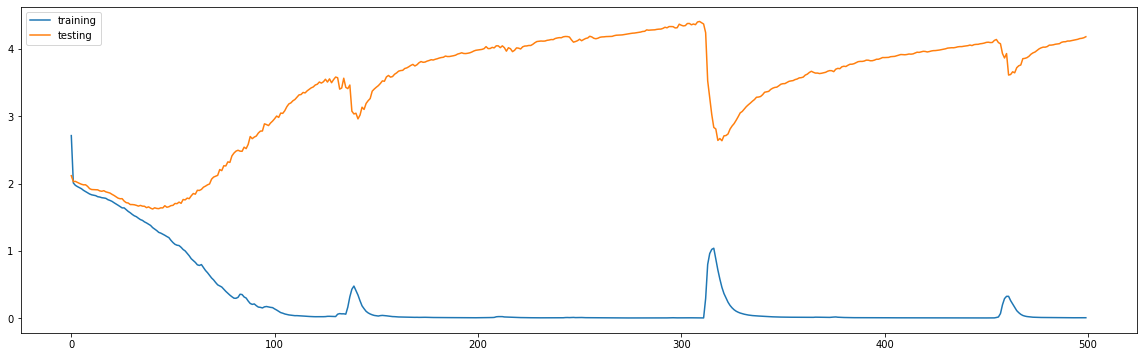

In [77]:
plt.figure(figsize=(20, 6))

plt.plot(hist.history['loss'], label='training')
plt.plot(hist.history['val_loss'], label='testing')
plt.legend()

plt.savefig(f'figures/{name}', dpi=400)

In [78]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_embedding_outputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [79]:
encoder_model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 64)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 64, 32)            1184      
_________________________________________________________________
lstm_7 (LSTM)                [(None, 256), (None, 256) 295936    
Total params: 297,120
Trainable params: 297,120
Non-trainable params: 0
_________________________________________________________________


In [80]:
decoder_model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 64)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 64, 32)       1184        input_12[0][0]                   
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 256)]        0                                            
___________________________________________________________________________________________

In [81]:
results = np.zeros((num_train, timesteps))
train_encoded = encoder_model.predict(encoder_inputs_training[:,:,np.newaxis])
train_inputs = np.ones((num_train, timesteps + 1)) * n2v_mapping['<bon/>']
for i in range(timesteps):
    decoded_results = decoder_model.predict([train_inputs[:,i+1].reshape(-1, 1)] + train_encoded)
    train_encoded = decoded_results[1:]
    #preds = decoded_results[0].argmax(-1)
    train_inputs[:,i+1] = decoded_results[0].argmax(-1).reshape(-1)

In [82]:
accuracy_score(encoder_inputs_training.reshape(-1), train_inputs[:,1:].reshape(-1))

0.3428308823529412

In [83]:
results = np.zeros((num_test, timesteps))
test_encoded = encoder_model.predict(encoder_inputs_testing[:,:,np.newaxis])
test_inputs = np.ones((num_test, timesteps + 1)) * n2v_mapping['<bon/>']
for i in range(timesteps):
    decoded_results = decoder_model.predict([test_inputs[:,i+1].reshape(-1, 1)] + test_encoded)
    test_encoded = decoded_results[1:]
    #preds = decoded_results[0].argmax(-1)
    test_inputs[:,i+1] = decoded_results[0].argmax(-1).reshape(-1)

In [84]:
accuracy_score(encoder_inputs_testing.reshape(-1), test_inputs[:,1:].reshape(-1))

0.33035714285714285

## Model 6: Variational Autoencoder

In [11]:
name = 'NBG_vae_dense'

In [12]:
original_dim = 64
intermediate_dim = 64
latent_dim = 2
embed_size = 16

ohe_inputs = Input(shape=(original_dim, vocab_size))
inputs = K.argmax(ohe_inputs)
embeddings = Embedding(vocab_size, embed_size)(inputs)
h = Dense(intermediate_dim, activation='relu')(embeddings)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [13]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(original_dim, latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling)([z_mean, z_log_sigma])

In [14]:
# Create encoder
encoder = Model(ohe_inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = Input(shape=(original_dim, latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(vocab_size, activation='softmax')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(ohe_inputs)[2])
vae = Model(ohe_inputs, outputs, name='vae_mlp')

In [15]:
reconstruction_loss = keras.losses.categorical_crossentropy(ohe_inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [16]:
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 36)]     0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 64, 2), (Non 1924        input_1[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 64, 36)       2532        encoder[0][2]                    
__________________________________________________________________________________________________
tf.math.argmax (TFOpLambda)     (None, 64)           0           input_1[0][0]                    
____________________________________________________________________________________________

In [17]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 64, 2)]           0         
_________________________________________________________________
dense_3 (Dense)              (None, 64, 64)            192       
_________________________________________________________________
dense_4 (Dense)              (None, 64, 36)            2340      
Total params: 2,532
Trainable params: 2,532
Non-trainable params: 0
_________________________________________________________________


In [19]:
mc = ModelCheckpoint(f'Models/{name}.hdf5', monitor='val_loss', save_format="tf")

hist = vae.fit(y_train, y_train,
        epochs=500,
        batch_size=32,
        validation_data=(y_test, y_test),
              callbacks=[mc]
              )

Epoch 1/500
6/6 [==============================] - 1s 109ms/step - loss: 226.1325 - val_loss: 224.2118
Epoch 2/500
6/6 [==============================] - 0s 21ms/step - loss: 223.6439 - val_loss: 220.9565
Epoch 3/500
6/6 [==============================] - 0s 17ms/step - loss: 219.9919 - val_loss: 216.9333
Epoch 4/500
6/6 [==============================] - 0s 18ms/step - loss: 215.5485 - val_loss: 210.4333
Epoch 5/500
6/6 [==============================] - 0s 21ms/step - loss: 208.6724 - val_loss: 202.3813
Epoch 6/500
6/6 [==============================] - 0s 20ms/step - loss: 200.5450 - val_loss: 190.7230
Epoch 7/500
6/6 [==============================] - 0s 18ms/step - loss: 188.6285 - val_loss: 175.9446
Epoch 8/500
6/6 [==============================] - 0s 21ms/step - loss: 172.0448 - val_loss: 154.9147
Epoch 9/500
6/6 [==============================] - 0s 21ms/step - loss: 151.5080 - val_loss: 131.2661
Epoch 10/500
6/6 [==============================] - 0s 21ms/step - loss: 126.7293

Epoch 23/500
6/6 [==============================] - 0s 21ms/step - loss: 57.2497 - val_loss: 48.0011
Epoch 24/500
6/6 [==============================] - 0s 24ms/step - loss: 52.6065 - val_loss: 46.4794
Epoch 25/500
6/6 [==============================] - 0s 23ms/step - loss: 52.7748 - val_loss: 45.1098
Epoch 26/500
6/6 [==============================] - 0s 20ms/step - loss: 50.6446 - val_loss: 43.7357
Epoch 27/500
6/6 [==============================] - 0s 23ms/step - loss: 48.5660 - val_loss: 42.4291
Epoch 28/500
6/6 [==============================] - 0s 24ms/step - loss: 49.2290 - val_loss: 41.2785
Epoch 29/500
6/6 [==============================] - 0s 24ms/step - loss: 47.2966 - val_loss: 40.1634
Epoch 30/500
6/6 [==============================] - 0s 25ms/step - loss: 46.7814 - val_loss: 39.1472
Epoch 31/500
6/6 [==============================] - 0s 19ms/step - loss: 44.4074 - val_loss: 38.2693
Epoch 32/500
6/6 [==============================] - 0s 19ms/step - loss: 43.8336 - val_loss

Epoch 45/500
6/6 [==============================] - 0s 20ms/step - loss: 33.7749 - val_loss: 28.8779
Epoch 46/500
6/6 [==============================] - 0s 20ms/step - loss: 34.1009 - val_loss: 28.2621
Epoch 47/500
6/6 [==============================] - 0s 22ms/step - loss: 31.6765 - val_loss: 27.7530
Epoch 48/500
6/6 [==============================] - 0s 21ms/step - loss: 30.7982 - val_loss: 27.2911
Epoch 49/500
6/6 [==============================] - 0s 19ms/step - loss: 31.7353 - val_loss: 26.7909
Epoch 50/500
6/6 [==============================] - 0s 21ms/step - loss: 31.5241 - val_loss: 26.3999
Epoch 51/500
6/6 [==============================] - 0s 22ms/step - loss: 30.8890 - val_loss: 26.0036
Epoch 52/500
6/6 [==============================] - 0s 40ms/step - loss: 28.8113 - val_loss: 25.6908
Epoch 53/500
6/6 [==============================] - 0s 22ms/step - loss: 28.7505 - val_loss: 25.2788
Epoch 54/500
6/6 [==============================] - 0s 19ms/step - loss: 28.3686 - val_loss

Epoch 67/500
6/6 [==============================] - 0s 23ms/step - loss: 23.5198 - val_loss: 21.3924
Epoch 68/500
6/6 [==============================] - 0s 20ms/step - loss: 24.4250 - val_loss: 21.2002
Epoch 69/500
6/6 [==============================] - 0s 20ms/step - loss: 24.0350 - val_loss: 20.9599
Epoch 70/500
6/6 [==============================] - 0s 23ms/step - loss: 23.1220 - val_loss: 20.7734
Epoch 71/500
6/6 [==============================] - 0s 22ms/step - loss: 23.7561 - val_loss: 20.6286
Epoch 72/500
6/6 [==============================] - 0s 18ms/step - loss: 23.0918 - val_loss: 20.3854
Epoch 73/500
6/6 [==============================] - 0s 19ms/step - loss: 22.0656 - val_loss: 20.1967
Epoch 74/500
6/6 [==============================] - 0s 22ms/step - loss: 22.2004 - val_loss: 19.9173
Epoch 75/500
6/6 [==============================] - 0s 20ms/step - loss: 23.1089 - val_loss: 19.7316
Epoch 76/500
6/6 [==============================] - 0s 22ms/step - loss: 22.3295 - val_loss

Epoch 89/500
6/6 [==============================] - 0s 20ms/step - loss: 20.6068 - val_loss: 17.3955
Epoch 90/500
6/6 [==============================] - 0s 25ms/step - loss: 18.2288 - val_loss: 17.2819
Epoch 91/500
6/6 [==============================] - 0s 19ms/step - loss: 18.7492 - val_loss: 17.1331
Epoch 92/500
6/6 [==============================] - 0s 48ms/step - loss: 19.4398 - val_loss: 16.9926
Epoch 93/500
6/6 [==============================] - 0s 24ms/step - loss: 18.7324 - val_loss: 16.8492
Epoch 94/500
6/6 [==============================] - 0s 20ms/step - loss: 18.3008 - val_loss: 16.8484
Epoch 95/500
6/6 [==============================] - 0s 20ms/step - loss: 18.3678 - val_loss: 16.6708
Epoch 96/500
6/6 [==============================] - 0s 18ms/step - loss: 19.3978 - val_loss: 16.4961
Epoch 97/500
6/6 [==============================] - 0s 21ms/step - loss: 17.8391 - val_loss: 16.2846
Epoch 98/500
6/6 [==============================] - 0s 19ms/step - loss: 18.5987 - val_loss

Epoch 111/500
6/6 [==============================] - 0s 21ms/step - loss: 16.6385 - val_loss: 14.6922
Epoch 112/500
6/6 [==============================] - 0s 21ms/step - loss: 15.4263 - val_loss: 14.5841
Epoch 113/500
6/6 [==============================] - 0s 21ms/step - loss: 16.2546 - val_loss: 14.4853
Epoch 114/500
6/6 [==============================] - 0s 22ms/step - loss: 16.1189 - val_loss: 14.3945
Epoch 115/500
6/6 [==============================] - 0s 19ms/step - loss: 15.2404 - val_loss: 14.2562
Epoch 116/500
6/6 [==============================] - 0s 21ms/step - loss: 15.6437 - val_loss: 14.1925
Epoch 117/500
6/6 [==============================] - 0s 23ms/step - loss: 15.4765 - val_loss: 14.0806
Epoch 118/500
6/6 [==============================] - 0s 19ms/step - loss: 15.9072 - val_loss: 14.0191
Epoch 119/500
6/6 [==============================] - 0s 20ms/step - loss: 15.1612 - val_loss: 13.9445
Epoch 120/500
6/6 [==============================] - 0s 21ms/step - loss: 14.8784 

Epoch 133/500
6/6 [==============================] - 0s 39ms/step - loss: 13.7216 - val_loss: 12.6231
Epoch 134/500
6/6 [==============================] - 0s 18ms/step - loss: 13.7265 - val_loss: 12.5398
Epoch 135/500
6/6 [==============================] - 0s 19ms/step - loss: 13.3056 - val_loss: 12.4399
Epoch 136/500
6/6 [==============================] - 0s 19ms/step - loss: 12.9113 - val_loss: 12.3773
Epoch 137/500
6/6 [==============================] - 0s 19ms/step - loss: 13.5574 - val_loss: 12.3299
Epoch 138/500
6/6 [==============================] - 0s 19ms/step - loss: 12.9918 - val_loss: 12.2415
Epoch 139/500
6/6 [==============================] - 0s 20ms/step - loss: 13.2005 - val_loss: 12.1547
Epoch 140/500
6/6 [==============================] - 0s 24ms/step - loss: 12.4364 - val_loss: 12.0583
Epoch 141/500
6/6 [==============================] - 0s 23ms/step - loss: 12.6400 - val_loss: 11.9454
Epoch 142/500
6/6 [==============================] - 0s 26ms/step - loss: 12.6109 

Epoch 155/500
6/6 [==============================] - 0s 22ms/step - loss: 11.7285 - val_loss: 10.8586
Epoch 156/500
6/6 [==============================] - 0s 21ms/step - loss: 11.0849 - val_loss: 10.7872
Epoch 157/500
6/6 [==============================] - 0s 20ms/step - loss: 11.7204 - val_loss: 10.6722
Epoch 158/500
6/6 [==============================] - 0s 20ms/step - loss: 11.1865 - val_loss: 10.6376
Epoch 159/500
6/6 [==============================] - 0s 22ms/step - loss: 11.2914 - val_loss: 10.5640
Epoch 160/500
6/6 [==============================] - 0s 21ms/step - loss: 10.6313 - val_loss: 10.5046
Epoch 161/500
6/6 [==============================] - 0s 20ms/step - loss: 10.9827 - val_loss: 10.3955
Epoch 162/500
6/6 [==============================] - 0s 21ms/step - loss: 10.8558 - val_loss: 10.3766
Epoch 163/500
6/6 [==============================] - 0s 23ms/step - loss: 10.9215 - val_loss: 10.3158
Epoch 164/500
6/6 [==============================] - 0s 21ms/step - loss: 11.4602 

Epoch 177/500
6/6 [==============================] - 0s 22ms/step - loss: 10.7211 - val_loss: 9.5229
Epoch 178/500
6/6 [==============================] - 0s 21ms/step - loss: 10.3010 - val_loss: 9.4451
Epoch 179/500
6/6 [==============================] - 0s 18ms/step - loss: 9.9502 - val_loss: 9.3641
Epoch 180/500
6/6 [==============================] - 0s 19ms/step - loss: 9.9114 - val_loss: 9.2972
Epoch 181/500
6/6 [==============================] - 0s 20ms/step - loss: 9.9754 - val_loss: 9.2198
Epoch 182/500
6/6 [==============================] - 0s 21ms/step - loss: 9.8633 - val_loss: 9.2354
Epoch 183/500
6/6 [==============================] - 0s 22ms/step - loss: 9.5306 - val_loss: 9.1811
Epoch 184/500
6/6 [==============================] - 0s 19ms/step - loss: 9.1064 - val_loss: 9.1498
Epoch 185/500
6/6 [==============================] - 0s 21ms/step - loss: 10.0194 - val_loss: 9.0611
Epoch 186/500
6/6 [==============================] - 0s 19ms/step - loss: 8.9377 - val_loss: 8.99

Epoch 199/500
6/6 [==============================] - 0s 20ms/step - loss: 8.5168 - val_loss: 8.3762
Epoch 200/500
6/6 [==============================] - 0s 20ms/step - loss: 8.7712 - val_loss: 8.3086
Epoch 201/500
6/6 [==============================] - 0s 21ms/step - loss: 8.3693 - val_loss: 8.2876
Epoch 202/500
6/6 [==============================] - 0s 18ms/step - loss: 8.8538 - val_loss: 8.2304
Epoch 203/500
6/6 [==============================] - 0s 20ms/step - loss: 8.7382 - val_loss: 8.1739
Epoch 204/500
6/6 [==============================] - 0s 22ms/step - loss: 7.9927 - val_loss: 8.1012
Epoch 205/500
6/6 [==============================] - 0s 19ms/step - loss: 8.6479 - val_loss: 8.0877
Epoch 206/500
6/6 [==============================] - 0s 20ms/step - loss: 8.6930 - val_loss: 8.0476
Epoch 207/500
6/6 [==============================] - 0s 20ms/step - loss: 8.6708 - val_loss: 7.9751
Epoch 208/500
6/6 [==============================] - 0s 23ms/step - loss: 8.1271 - val_loss: 7.9674


Epoch 221/500
6/6 [==============================] - 0s 19ms/step - loss: 7.8371 - val_loss: 7.3976
Epoch 222/500
6/6 [==============================] - 0s 19ms/step - loss: 7.8704 - val_loss: 7.3610
Epoch 223/500
6/6 [==============================] - 0s 20ms/step - loss: 8.0372 - val_loss: 7.3331
Epoch 224/500
6/6 [==============================] - 0s 22ms/step - loss: 7.4987 - val_loss: 7.2926
Epoch 225/500
6/6 [==============================] - 0s 25ms/step - loss: 7.5862 - val_loss: 7.2360
Epoch 226/500
6/6 [==============================] - 0s 22ms/step - loss: 7.3231 - val_loss: 7.2181
Epoch 227/500
6/6 [==============================] - 0s 20ms/step - loss: 7.2509 - val_loss: 7.1991
Epoch 228/500
6/6 [==============================] - 0s 19ms/step - loss: 7.2720 - val_loss: 7.1229
Epoch 229/500
6/6 [==============================] - 0s 20ms/step - loss: 7.1540 - val_loss: 7.1047
Epoch 230/500
6/6 [==============================] - 0s 23ms/step - loss: 6.7938 - val_loss: 7.0479


Epoch 243/500
6/6 [==============================] - 0s 20ms/step - loss: 6.4426 - val_loss: 6.6639
Epoch 244/500
6/6 [==============================] - 0s 20ms/step - loss: 6.7017 - val_loss: 6.6330
Epoch 245/500
6/6 [==============================] - 0s 23ms/step - loss: 6.6257 - val_loss: 6.5989
Epoch 246/500
6/6 [==============================] - 0s 23ms/step - loss: 6.5274 - val_loss: 6.5718
Epoch 247/500
6/6 [==============================] - 0s 22ms/step - loss: 6.6553 - val_loss: 6.5266
Epoch 248/500
6/6 [==============================] - 0s 23ms/step - loss: 6.4593 - val_loss: 6.5294
Epoch 249/500
6/6 [==============================] - 0s 18ms/step - loss: 6.6594 - val_loss: 6.4968
Epoch 250/500
6/6 [==============================] - 0s 21ms/step - loss: 6.5267 - val_loss: 6.4906
Epoch 251/500
6/6 [==============================] - 0s 21ms/step - loss: 6.4265 - val_loss: 6.4484
Epoch 252/500
6/6 [==============================] - 0s 19ms/step - loss: 6.2636 - val_loss: 6.4295


Epoch 265/500
6/6 [==============================] - 0s 23ms/step - loss: 5.9066 - val_loss: 6.0494
Epoch 266/500
6/6 [==============================] - 0s 20ms/step - loss: 5.7144 - val_loss: 5.9925
Epoch 267/500
6/6 [==============================] - 0s 20ms/step - loss: 5.6590 - val_loss: 5.9668
Epoch 268/500
6/6 [==============================] - 0s 25ms/step - loss: 6.1961 - val_loss: 5.9336
Epoch 269/500
6/6 [==============================] - 0s 24ms/step - loss: 5.8942 - val_loss: 5.9388
Epoch 270/500
6/6 [==============================] - 0s 20ms/step - loss: 5.6665 - val_loss: 5.8839
Epoch 271/500
6/6 [==============================] - 0s 22ms/step - loss: 5.9933 - val_loss: 5.9036
Epoch 272/500
6/6 [==============================] - 0s 20ms/step - loss: 5.5175 - val_loss: 5.9036
Epoch 273/500
6/6 [==============================] - 0s 20ms/step - loss: 5.8440 - val_loss: 5.9042
Epoch 274/500
6/6 [==============================] - 0s 22ms/step - loss: 5.9243 - val_loss: 5.8648


Epoch 287/500
6/6 [==============================] - 0s 21ms/step - loss: 5.1890 - val_loss: 5.5174
Epoch 288/500
6/6 [==============================] - 0s 20ms/step - loss: 5.2297 - val_loss: 5.4853
Epoch 289/500
6/6 [==============================] - 0s 22ms/step - loss: 5.2456 - val_loss: 5.4646
Epoch 290/500
6/6 [==============================] - 0s 22ms/step - loss: 5.4842 - val_loss: 5.4688
Epoch 291/500
6/6 [==============================] - 0s 20ms/step - loss: 5.2883 - val_loss: 5.4249
Epoch 292/500
6/6 [==============================] - 0s 20ms/step - loss: 5.0423 - val_loss: 5.4488
Epoch 293/500
6/6 [==============================] - 0s 20ms/step - loss: 5.2025 - val_loss: 5.4149
Epoch 294/500
6/6 [==============================] - 0s 23ms/step - loss: 5.2928 - val_loss: 5.3985
Epoch 295/500
6/6 [==============================] - 0s 47ms/step - loss: 5.1194 - val_loss: 5.3819
Epoch 296/500
6/6 [==============================] - 0s 21ms/step - loss: 4.9481 - val_loss: 5.3753


Epoch 309/500
6/6 [==============================] - 0s 23ms/step - loss: 4.8893 - val_loss: 5.1070
Epoch 310/500
6/6 [==============================] - 0s 22ms/step - loss: 4.7832 - val_loss: 5.0671
Epoch 311/500
6/6 [==============================] - 0s 21ms/step - loss: 4.9267 - val_loss: 5.0790
Epoch 312/500
6/6 [==============================] - 0s 21ms/step - loss: 4.8392 - val_loss: 5.0540
Epoch 313/500
6/6 [==============================] - 0s 19ms/step - loss: 5.1210 - val_loss: 5.0337
Epoch 314/500
6/6 [==============================] - 0s 21ms/step - loss: 4.8025 - val_loss: 5.0427
Epoch 315/500
6/6 [==============================] - 0s 19ms/step - loss: 4.9685 - val_loss: 5.0243
Epoch 316/500
6/6 [==============================] - 0s 20ms/step - loss: 4.6589 - val_loss: 5.0070
Epoch 317/500
6/6 [==============================] - 0s 25ms/step - loss: 4.6438 - val_loss: 4.9975
Epoch 318/500
6/6 [==============================] - 0s 20ms/step - loss: 4.6190 - val_loss: 4.9480


Epoch 331/500
6/6 [==============================] - 0s 19ms/step - loss: 4.3139 - val_loss: 4.7161
Epoch 332/500
6/6 [==============================] - 0s 20ms/step - loss: 4.4034 - val_loss: 4.6870
Epoch 333/500
6/6 [==============================] - 0s 20ms/step - loss: 4.2336 - val_loss: 4.6796
Epoch 334/500
6/6 [==============================] - 0s 19ms/step - loss: 4.4540 - val_loss: 4.6647
Epoch 335/500
6/6 [==============================] - 0s 45ms/step - loss: 4.3823 - val_loss: 4.6314
Epoch 336/500
6/6 [==============================] - 0s 18ms/step - loss: 4.2562 - val_loss: 4.6056
Epoch 337/500
6/6 [==============================] - 0s 19ms/step - loss: 4.3835 - val_loss: 4.6083
Epoch 338/500
6/6 [==============================] - 0s 20ms/step - loss: 4.4073 - val_loss: 4.6232
Epoch 339/500
6/6 [==============================] - 0s 19ms/step - loss: 4.3325 - val_loss: 4.6203
Epoch 340/500
6/6 [==============================] - 0s 19ms/step - loss: 4.1884 - val_loss: 4.6291


Epoch 353/500
6/6 [==============================] - 0s 24ms/step - loss: 3.9958 - val_loss: 4.3958
Epoch 354/500
6/6 [==============================] - 0s 22ms/step - loss: 3.9550 - val_loss: 4.3534
Epoch 355/500
6/6 [==============================] - 0s 22ms/step - loss: 4.0481 - val_loss: 4.3502
Epoch 356/500
6/6 [==============================] - 0s 23ms/step - loss: 3.8588 - val_loss: 4.3331
Epoch 357/500
6/6 [==============================] - 0s 26ms/step - loss: 4.0392 - val_loss: 4.2955
Epoch 358/500
6/6 [==============================] - 0s 27ms/step - loss: 3.9644 - val_loss: 4.2734
Epoch 359/500
6/6 [==============================] - 0s 24ms/step - loss: 3.9580 - val_loss: 4.2920
Epoch 360/500
6/6 [==============================] - 0s 22ms/step - loss: 3.8926 - val_loss: 4.2596
Epoch 361/500
6/6 [==============================] - 0s 24ms/step - loss: 3.8742 - val_loss: 4.2427
Epoch 362/500
6/6 [==============================] - 0s 24ms/step - loss: 4.0614 - val_loss: 4.2551


Epoch 375/500
6/6 [==============================] - 0s 20ms/step - loss: 3.7803 - val_loss: 4.1045
Epoch 376/500
6/6 [==============================] - 0s 36ms/step - loss: 3.6011 - val_loss: 4.0987
Epoch 377/500
6/6 [==============================] - 0s 20ms/step - loss: 3.5347 - val_loss: 4.0746
Epoch 378/500
6/6 [==============================] - 0s 21ms/step - loss: 3.7564 - val_loss: 4.0917
Epoch 379/500
6/6 [==============================] - 0s 19ms/step - loss: 3.6374 - val_loss: 4.0921
Epoch 380/500
6/6 [==============================] - 0s 19ms/step - loss: 3.7142 - val_loss: 4.0817
Epoch 381/500
6/6 [==============================] - 0s 21ms/step - loss: 3.6852 - val_loss: 4.0668
Epoch 382/500
6/6 [==============================] - 0s 18ms/step - loss: 3.6880 - val_loss: 4.0607
Epoch 383/500
6/6 [==============================] - 0s 20ms/step - loss: 3.7251 - val_loss: 4.0499
Epoch 384/500
6/6 [==============================] - 0s 17ms/step - loss: 3.5783 - val_loss: 4.0288


Epoch 397/500
6/6 [==============================] - 0s 19ms/step - loss: 3.6696 - val_loss: 3.9329
Epoch 398/500
6/6 [==============================] - 0s 20ms/step - loss: 3.5929 - val_loss: 3.9251
Epoch 399/500
6/6 [==============================] - 0s 18ms/step - loss: 3.4335 - val_loss: 3.9505
Epoch 400/500
6/6 [==============================] - 0s 20ms/step - loss: 3.5075 - val_loss: 3.9381
Epoch 401/500
6/6 [==============================] - 0s 21ms/step - loss: 3.4651 - val_loss: 3.9079
Epoch 402/500
6/6 [==============================] - 0s 19ms/step - loss: 3.3193 - val_loss: 3.9059
Epoch 403/500
6/6 [==============================] - 0s 20ms/step - loss: 3.3392 - val_loss: 3.8768
Epoch 404/500
6/6 [==============================] - 0s 22ms/step - loss: 3.3309 - val_loss: 3.8545
Epoch 405/500
6/6 [==============================] - 0s 23ms/step - loss: 3.4950 - val_loss: 3.8540
Epoch 406/500
6/6 [==============================] - 0s 21ms/step - loss: 3.4429 - val_loss: 3.8252


Epoch 419/500
6/6 [==============================] - 0s 20ms/step - loss: 3.3107 - val_loss: 3.6519
Epoch 420/500
6/6 [==============================] - 0s 25ms/step - loss: 3.1633 - val_loss: 3.6042
Epoch 421/500
6/6 [==============================] - 0s 23ms/step - loss: 3.0994 - val_loss: 3.6134
Epoch 422/500
6/6 [==============================] - 0s 21ms/step - loss: 3.2758 - val_loss: 3.6077
Epoch 423/500
6/6 [==============================] - 0s 22ms/step - loss: 3.1271 - val_loss: 3.5913
Epoch 424/500
6/6 [==============================] - 0s 24ms/step - loss: 3.0744 - val_loss: 3.6173
Epoch 425/500
6/6 [==============================] - 0s 23ms/step - loss: 2.9906 - val_loss: 3.5681
Epoch 426/500
6/6 [==============================] - 0s 23ms/step - loss: 3.0380 - val_loss: 3.5899
Epoch 427/500
6/6 [==============================] - 0s 20ms/step - loss: 3.0836 - val_loss: 3.5856
Epoch 428/500
6/6 [==============================] - 0s 22ms/step - loss: 3.0687 - val_loss: 3.6002


Epoch 441/500
6/6 [==============================] - 0s 19ms/step - loss: 2.9371 - val_loss: 3.4976
Epoch 442/500
6/6 [==============================] - 0s 17ms/step - loss: 2.9026 - val_loss: 3.4575
Epoch 443/500
6/6 [==============================] - 0s 20ms/step - loss: 2.9932 - val_loss: 3.4445
Epoch 444/500
6/6 [==============================] - 0s 19ms/step - loss: 3.0704 - val_loss: 3.4577
Epoch 445/500
6/6 [==============================] - 0s 22ms/step - loss: 2.9621 - val_loss: 3.4596
Epoch 446/500
6/6 [==============================] - 0s 22ms/step - loss: 3.0995 - val_loss: 3.4482
Epoch 447/500
6/6 [==============================] - 0s 20ms/step - loss: 2.8880 - val_loss: 3.4604
Epoch 448/500
6/6 [==============================] - 0s 22ms/step - loss: 2.9525 - val_loss: 3.4156
Epoch 449/500
6/6 [==============================] - 0s 20ms/step - loss: 2.8447 - val_loss: 3.3854
Epoch 450/500
6/6 [==============================] - 0s 22ms/step - loss: 2.8913 - val_loss: 3.4111


Epoch 463/500
6/6 [==============================] - 0s 21ms/step - loss: 2.7659 - val_loss: 3.1870
Epoch 464/500
6/6 [==============================] - 0s 21ms/step - loss: 2.9065 - val_loss: 3.1801
Epoch 465/500
6/6 [==============================] - 0s 22ms/step - loss: 2.9739 - val_loss: 3.2204
Epoch 466/500
6/6 [==============================] - 0s 22ms/step - loss: 2.7286 - val_loss: 3.2268
Epoch 467/500
6/6 [==============================] - 0s 21ms/step - loss: 2.7452 - val_loss: 3.2008
Epoch 468/500
6/6 [==============================] - 0s 24ms/step - loss: 2.7198 - val_loss: 3.2114
Epoch 469/500
6/6 [==============================] - 0s 19ms/step - loss: 2.7730 - val_loss: 3.2184
Epoch 470/500
6/6 [==============================] - 0s 20ms/step - loss: 2.7042 - val_loss: 3.2075
Epoch 471/500
6/6 [==============================] - 0s 21ms/step - loss: 2.7387 - val_loss: 3.2381
Epoch 472/500
6/6 [==============================] - 0s 23ms/step - loss: 2.6089 - val_loss: 3.1909


Epoch 485/500
6/6 [==============================] - 0s 18ms/step - loss: 2.6602 - val_loss: 3.0521
Epoch 486/500
6/6 [==============================] - 0s 19ms/step - loss: 2.6806 - val_loss: 3.0540
Epoch 487/500
6/6 [==============================] - 0s 19ms/step - loss: 2.5341 - val_loss: 3.0536
Epoch 488/500
6/6 [==============================] - 0s 23ms/step - loss: 2.7935 - val_loss: 3.0282
Epoch 489/500
6/6 [==============================] - 0s 20ms/step - loss: 2.7819 - val_loss: 3.0433
Epoch 490/500
6/6 [==============================] - 0s 23ms/step - loss: 2.5376 - val_loss: 3.0676
Epoch 491/500
6/6 [==============================] - 0s 23ms/step - loss: 2.5653 - val_loss: 3.0038
Epoch 492/500
6/6 [==============================] - 0s 23ms/step - loss: 2.4840 - val_loss: 3.0165
Epoch 493/500
6/6 [==============================] - 0s 22ms/step - loss: 2.4790 - val_loss: 2.9633
Epoch 494/500
6/6 [==============================] - 0s 21ms/step - loss: 2.5749 - val_loss: 2.9557


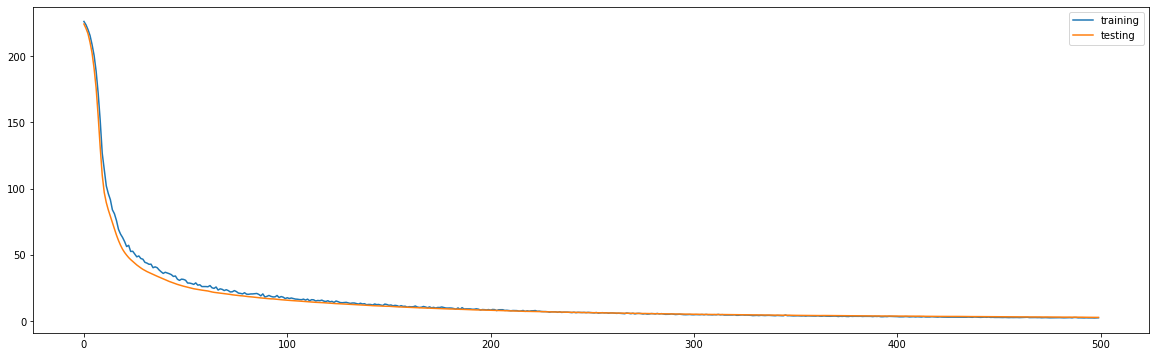

In [20]:
plt.figure(figsize=(20, 6))

plt.plot(hist.history['loss'], label='training')
plt.plot(hist.history['val_loss'], label='testing')
plt.legend()

plt.savefig(f'figures/{name}', dpi=400)

In [21]:
vae = load_model(f'Models/{name}.hdf5')

In [22]:
preds = vae(y_train).numpy().argmax(-1)

accuracy_score(X_train.reshape(-1), preds.reshape(-1))

0.9987763554216867

In [23]:
preds = vae(y_test).numpy().argmax(-1)

accuracy_score(X_test.reshape(-1), preds.reshape(-1))

0.9951636904761905

In [24]:
n=30

grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
lst=[]

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]] * 64)[np.newaxis,:,:]
        x_decoded = decoder.predict(z_sample)
        lst.append(x_decoded)

In [ ]:
preds = decoder.predict(np.random.normal(size=(10, 64, 2)))
preds.argmax(-1)

In [ ]:
generation = decoder(np.random.normal(size=(10, 64, 2))).numpy()

In [ ]:
train_encoded = encoder(y_train)[2].numpy()

In [ ]:
[[1,2]] * 10

In [ ]:
train_encoded[0]

In [ ]:
decoder.predict(train_encoded).argmax(-1)

In [ ]:
generation.argmax(-1)

In [ ]:
x_test_encoded = encoder.predict(y_test, batch_size=32)[2]

plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [ ]:
x_test_encoded[2].shape